<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/getHAFSASlices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program subsets and saves portions of output from the MOM6 model along the track of a given TC.

#Set up environment

In [2]:
!pip install cfgrib
!pip install cartopy
!pip install tropycal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 77.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tropycal: filename=tropycal-1.3-py3-none-any.whl size=242631 sha256=d433aa0b6ce7b5f252d8e9f2c8e4667f3daa2f622c17748d20df05ebc785c341
  Stored in directory: /root/.cache/pip/wheels/45/b3/db/78c9a2a51e8db2d962647d8dd0bb4e1ed5e1005254353de4af
Successfully built tropycal


In [33]:
!sudo apt install aria2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 1s (2,292 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to front

In [3]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
import cfgrib
import numpy as np

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#User parameters

In [26]:
name = "Milton"
tcNum = "14"
filepath = f"/content/drive/MyDrive/ColabNotebooks/{name}"
trackType = ""

centralTime = dt(year=2024, month=10, day=7, hour=6) #Time when Milton began its most rapid intensification
daysBefore = 1 #Days before the focal point
daysAfter = 1 #Days after focal point

fHourStep = 6 #Normally 3 for HAFS-A
forecastLength = 36 #Normally 126 for HAFS-A. Changeable for testing.
runStep = 12 #Normally 6 for HAFS-A

figureSuffix = "_RI"

In [27]:
atmTop = 700 # in hPa
oceBottom = 530 # In m below surface. This was chosen to include a layer in the files that's around 529 m

Get best track data and find interested point

In [28]:
bt = pd.read_csv(filepath + "/hurdat2_" + name + trackType + ".csv")
latBounds = [min(bt.lat), max(bt.lat)]
lonBounds = [min(bt.lon), max(bt.lon)]

#Retrieve MOM6 Data

In [29]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = centralTime - pd.Timedelta(days=daysBefore)
end = centralTime + pd.Timedelta(days=daysAfter)

Find times needed

In [30]:
fcastTimes = {} #Key: initiation, item: valid time list

initTime = start
while initTime <= end:
  validTime = initTime
  fcastTimes[initTime] = []
  fhour = 0

  while validTime <= end and fhour <= forecastLength:
    fcastTimes[initTime].append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

  initTime += pd.Timedelta(hours=runStep)

Get data from HAFS-A output.

In [31]:
bucket = "https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/"

In [49]:
for init, validList in fcastTimes.items():

  initDate, initHour = init.strftime("%Y%m%d_%H").split("_")

  for valid in validList:

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    atmURL = bucket + initDate + "/" + initHour + "/" + tcNum + "l." + initDate + initHour + ".hfsa.storm.atm.f" + fhour + ".grb2"
    atmFile = "atm_" + initDate + "_" + initHour + "_f" + fhour + ".grb2"

    !aria2c -x 16 -s 16 --allow-overwrite=true -o {atmFile} {atmURL}

    atmData = xr.open_dataset(atmFile, engine="cfgrib", decode_timedelta=True, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa'})
    #Longitude in atm files are in degrees east, but are -180 - 180 in oce files. point has them from -180 - 180

    pressureSlice = slice(max(atmData.isobaricInhPa.data), atmTop)
    atmSlice = atmData.sel(latitude=slice(latBounds[0], latBounds[1]), longitude=slice(360+lonBounds[0], 360+lonBounds[1]), isobaricInhPa=pressureSlice)
    atmSlice.to_netcdf("hafsa_" + initDate + "_" + initHour + "_f" + fhour + ".nc")

    !rm {atmFile}


06/16 21:27:12 [NOTICE] Downloading 1 item(s)

06/16 21:27:13 [NOTICE] Shutdown sequence commencing... Press Ctrl-C again for emergency shutdown.

06/16 21:27:13 [NOTICE] Emergency shutdown sequence commencing...

06/16 21:27:13 [NOTICE] Download GID#602c2c4f1edc1ffd not complete: /content/atm_20241006_06_f000.grb2

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
602c2c|INPR|    11MiB/s|/content/atm_20241006_06_f000.grb2

Status Legend:
(INPR):download in-progress.

aria2 will resume download if the transfer is restarted.
If there are any errors, then see the log file. See '-l' option in help/man page for details.


KeyboardInterrupt: 

In [54]:
for init, validList in fcastTimes.items():

  initDate, initHour = init.strftime("%Y%m%d_%H").split("_")

  for valid in validList:

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    oceURL = bucket + initDate + "/" + initHour + "/" + tcNum + "l." + initDate + initHour + ".hfsa.mom6.f" + fhour + ".nc"
    oceFile = "oce_" + initDate + "_" + initHour + "_f" + fhour + ".nc"

    #if oceFile != 'oce_20241008_00_f000.nc': #This file is missing
    !aria2c -x 16 -s 16 --allow-overwrite=true -o {oceFile} {oceURL}
    oceData = xr.open_dataset(oceFile, decode_times=False)

    depthSlice = slice(min(oceData.z_l.data), oceBottom)
    oceSlice = oceData.sel(z_l=depthSlice, z_i=depthSlice,\
                           xh=slice(lonBounds[0],lonBounds[1]), yh=slice(latBounds[0],latBounds[1]),\
                           xq=slice(lonBounds[0],lonBounds[1]), yq=slice(latBounds[0],latBounds[1]))
    oceSlice.to_netcdf("mom6_" + initDate + "_" + initHour + "_f" + fhour + ".nc")

    !rm {oceFile}


06/16 21:33:24 [NOTICE] Downloading 1 item(s)

06/16 21:33:37 [NOTICE] Download complete: /content/oce_20241006_06_f000.nc

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
b5b52e|OK  |   197MiB/s|/content/oce_20241006_06_f000.nc

Status Legend:
(OK):download completed.

06/16 21:33:40 [NOTICE] Downloading 1 item(s)

06/16 21:33:53 [NOTICE] Download complete: /content/oce_20241006_06_f006.nc

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
f8e41b|OK  |   186MiB/s|/content/oce_20241006_06_f006.nc

Status Legend:
(OK):download completed.

06/16 21:33:55 [NOTICE] Downloading 1 item(s)

06/16 21:34:10 [NOTICE] Emergency shutdown sequence commencing...
^C


KeyboardInterrupt: 

In [53]:
oceSlice

<xarray.Dataset> Size: 67MB
Dimensions:    (xh: 0, yh: 121, time: 1, xq: 2414, yq: 965, z_l: 28, z_i: 56)
Coordinates:
  * xh         (xh) float64 0B 
  * yh         (yh) float64 968B 20.81 20.88 20.96 21.03 ... 29.35 29.42 29.49
  * time       (time) float64 8B 0.1
  * xq         (xq) float64 19kB -178.0 -178.0 -177.9 ... 14.84 14.92 15.0
  * yq         (yq) float64 8kB -23.07 -23.0 -22.92 -22.85 ... 46.91 46.96 47.01
  * z_l        (z_l) float64 224B 1.0 3.5 7.5 12.82 ... 332.5 385.4 450.2 528.9
  * z_i        (z_i) float64 448B 0.0 2.0 5.0 ... 5.29e+03 5.499e+03 5.708e+03
Data variables: (12/37)
    geolon     (yh, xh) float32 0B ...
    geolat     (yh, xh) float32 0B ...
    geolon_c   (yq, xq) float32 9MB ...
    geolat_c   (yq, xq) float32 9MB ...
    geolon_u   (yh, xq) float32 1MB ...
    geolat_u   (yh, xq) float32 1MB ...
    ...         ...
    evap       (time, yh, xh) float32 0B ...
    lprec      (time, yh, xh) float32 0B ...
    lrunoff    (time, yh, xh) float32 0B ...
    fprec      (time, yh, xh) float32 0B ...
    LwLatSens  (time, yh, xh) float32 0B ...
    Heat_PmE   (time, yh, xh) float32 0B ...
Attributes:
    NumFilesInSet:  1
    title:          ufs.hafs
    grid_type:      regular
    grid_tile:      N/A

In [56]:
oce = xr.open_dataset("/content/mom6_20241006_06_f000.nc", decode_times=False)

(array([1.00300e+03, 3.46400e+03, 1.79620e+04, 1.40685e+05, 6.12289e+05,
        1.64109e+05, 3.17190e+04, 1.22410e+04, 3.16500e+03, 4.11000e+02]),
 array([-1.24726284, -0.97324181, -0.69922072, -0.42519963, -0.1511786 ,
         0.12284243,  0.39686358,  0.67088461,  0.94490564,  1.21892679,
         1.4929477 ]),
 <BarContainer object of 10 artists>)

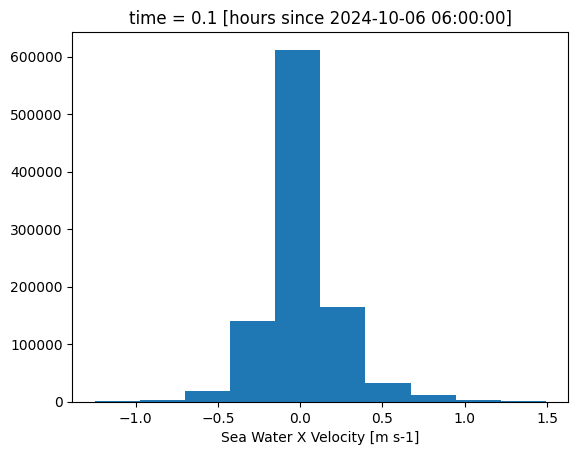

In [58]:
oce.uo.